In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import csv
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy import stats
from category_encoders import CatBoostEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import uniform 
from numpy.random import RandomState
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor 
from mlxtend.frequent_patterns import apriori

In [2]:
# Importing necessary files
movie = pd.read_csv("movie.csv")
rating = pd.read_csv("rating.csv")

In [3]:
# Take a first look at movie df
movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Noticing that there is no missing data in movie dataset
movie.isnull().sum()

# Duplicate movies are dropped
movie=movie[~movie["title"].duplicated()]

In [5]:
# Movie year is extracted from the movie title
movie["movie_year"] = movie["title"].str.slice(start=-7,stop=-1)
movie["movie_year"] = movie.movie_year.str.extract('(\d+)')
movie["movie_year"] = pd.to_numeric(movie["movie_year"])

# Descriptive statistics of the movie df
movie.describe()

,movieId,movie_year
count,27262.000000,27243.000000
mean,59835.761793,1989.290827
std,44427.347605,26.252699
min,1.000000,5.000000
25%,6927.250000,1976.000000
50%,68033.500000,1998.000000
75%,100274.250000,2008.000000
max,131262.000000,2015.000000


In [6]:
# The movie with the year value of 5 is dropped
movie = movie.loc[(movie['movie_year'] > 5)].copy()

# Descriptive stats of movie df
movie.describe()

,movieId,movie_year
count,27242.000000,27242.000000
mean,59794.993723,1989.363666
std,44414.186786,23.338473
min,1.000000,1891.000000
25%,6921.500000,1976.000000
50%,67930.000000,1998.000000
75%,100247.500000,2008.000000
max,131262.000000,2015.000000


In [7]:
# Checking whether there is a missig data in the movie df
movie.isnull().sum()

movieId       0
title         0
genres        0
movie_year    0
dtype: int64

In [8]:
# Dropping the movies that don't have release year
movie = movie.copy().dropna()

# Getting the movie df
movie.head()

,movieId,title,genres,movie_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [9]:
# Splitting multiple genres that a movie has and storing each genre as a seperate column
genres = movie['genres'].str.get_dummies('|')
movie = pd.concat([movie, genres], axis=1)

# Dropping genres column
movie.drop('genres', axis='columns',inplace=True)

# Getting the movie df
movie.head(5)

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Checking whether movieID is unique
movie.movieId.value_counts()

2047      1
90049     1
91908     1
92102     1
6088      1
         ..
7336      1
86911     1
43904     1
33669     1
131072    1
Name: movieId, Length: 27242, dtype: int64

In [11]:
# Counting the number of movies for each genre
genres_count = movie.sum(axis = 0, skipna = True)
genres_count = genres_count.to_frame()
genres_count = genres_count.drop(genres_count.index[range(3)])
genres_count.columns =['Count']
genres_count.reset_index(inplace=True)
genres_count.rename(columns={"index": "Genre"},inplace = True)
genres_count

,Genre,Count
0,(no genres listed),237
1,Action,3518
2,Adventure,2328
3,Animation,1025
4,Children,1138
5,Comedy,8366
6,Crime,2937
7,Documentary,2467
8,Drama,13332
9,Fantasy,1410


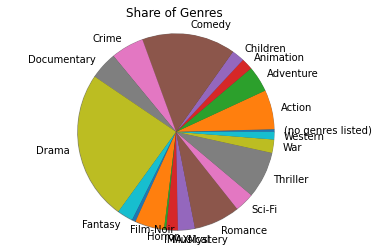

In [12]:
# Pie plot of movie count of different genres
plt.pie(genres_count["Count"], labels = genres_count["Genre"],shadow=True,radius = 10, center = (5,5))
plt.title("Share of Genres")
plt.axis('equal')
plt.show()

In [13]:
# First glance to rating dataset
rating

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [14]:
# Noticing that there is no missing data in rating dataset
rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [15]:
# Duplicate lines are dropped
rating = rating[~rating.duplicated()]

# Check whether there is an outlier in the rating
rating.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


NameError: name 'draft' is not defined

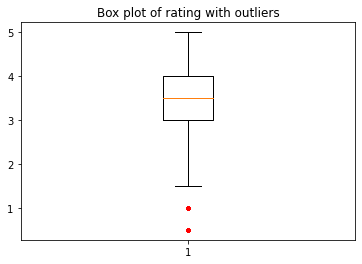

In [16]:
# Outlier Analysis

# Plotting box plot based on price attribute
plt.boxplot(rating["rating"], sym= "r.")
plt.title("Box plot of rating with outliers")
plt.show()

In [17]:
# Looking at the rating df
rating

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [18]:
# Dropping the rating timestamp since it wouldn't be used in the following analysis
rating.drop('timestamp', axis='columns',inplace=True)

In [19]:
# Only rated with 5 is stored
rated_with_5 = rating.loc[(rating['rating'] >= 5)].copy()
rated_with_5

,userId,movieId,rating
131,1,4993,5.0
142,1,5952,5.0
158,1,7153,5.0
170,1,8507,5.0
176,2,62,5.0
...,...,...,...
20000230,138493,48780,5.0
20000244,138493,55269,5.0
20000245,138493,55814,5.0
20000251,138493,59784,5.0


In [20]:
# Joining movies and rating for top movies
movie_with_rating = pd.merge(movie, rating)
movie_with_rating

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3,4.0
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,6,5.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,8,4.0
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,10,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,11,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999359,131254,Kein Bund für's Leben (2007),2007.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,79570,4.0
19999360,131256,"Feuer, Eis & Dosenbier (2002)",2002.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,79570,4.0
19999361,131258,The Pirates (2014),2014.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,28906,2.5
19999362,131260,Rentun Ruusu (2001),2001.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,65409,3.0


In [21]:
# Most watched movies
movie_with_rating["title"].value_counts().head(10)  

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: title, dtype: int64

# Top Rated Movies

In [22]:
# At least 100 times rated movies are kept 
watched_enough = movie_with_rating['movieId'].value_counts()[movie_with_rating['movieId'].value_counts() > 100].index
top_chart = movie_with_rating[movie_with_rating['movieId'].isin(watched_enough)].copy()
top_chart = top_chart.groupby(['title']).mean().copy()

# Keeping only title and rating columns 
col_list = ["title","rating"]
top_chart_for_figure = top_chart.drop(top_chart.columns.difference(col_list), axis=1).copy()
top_chart_for_figure.sort_values(by = ['rating'], ascending = False).head(10)

,rating
title,
"Shawshank Redemption, The (1994)",4.446990
"Godfather, The (1972)",4.364732
"Usual Suspects, The (1995)",4.334372
Schindler's List (1993),4.310175
"Godfather: Part II, The (1974)",4.275641
Seven Samurai (Shichinin no samurai) (1954),4.274180
Rear Window (1954),4.271334
Band of Brothers (2001),4.263182
Casablanca (1942),4.258327


In [23]:
# Converting index as a column contains movie titles
top_chart['Movie'] = top_chart.index

# Genre-based Top Movies

In [24]:
# Loop for selecting top ranked movie of each genre
best_rat = []
movie_list = []
for j in range(19):
    best_rating = 0 
    for i in range(len(top_chart)):
        if top_chart.iloc[i,j+3] == 1:
            if top_chart.iloc[i,23] > best_rating :
                best_rating = top_chart.iloc[i,23]
                movies = top_chart.iloc[i,24]
                
    best_rat.append(best_rating)   
    movie_list.append(movies)
    
# Getting the name of each genre
colname = top_chart.columns[3:21]

# Obtaining the top chart 
genre_based_top_chart = pd.DataFrame(list(zip(colname,movie_list,  best_rat)),
              columns=['Genre','Movie', 'Rating'])

genre_based_top_chart

,Genre,Movie,Rating
0,Action,Seven Samurai (Shichinin no samurai) (1954),4.274180
1,Adventure,Seven Samurai (Shichinin no samurai) (1954),4.274180
2,Animation,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.203810
3,Children,Wallace & Gromit: The Wrong Trousers (1993),4.181068
4,Comedy,Dr. Strangelove or: How I Learned to Stop Worr...,4.247287
5,Crime,"Shawshank Redemption, The (1994)",4.446990
6,Documentary,Cosmos (1980),4.220620
7,Drama,"Shawshank Redemption, The (1994)",4.446990
8,Fantasy,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.203810
9,Film-Noir,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.256935


# Year-Based Top Movies

In [25]:
# Years to be listed
years = [2000,2001,2002,2003,2004,2005,2006,2007,
        2008,2009,2010,2011,2012,2013,2014,2015]

# Loop for selecting top ranked movie of each year
best_rat_for_year = []
movie_list_for_year = []
for j in range(16):
    best_rating_year = 0 
    for i in range(len(top_chart)):
        if top_chart.iloc[i,1] == years[j]:
            if top_chart.iloc[i,23] > best_rating_year :
                best_rating_year = top_chart.iloc[i,23]
                movies_year = top_chart.iloc[i,24]
                
    best_rat_for_year.append(best_rating_year)   
    movie_list_for_year.append(movies_year)

# Obtaining the top chart 
year_based_top_chart = pd.DataFrame(list(zip(years,movie_list_for_year,  best_rat_for_year)),
              columns=['Year','Movie', 'Rating'])

year_based_top_chart

,Year,Movie,Rating
0,2000,Memento (2000),4.178547
1,2001,Band of Brothers (2001),4.263182
2,2002,City of God (Cidade de Deus) (2002),4.235410
3,2003,"Lord of the Rings: The Return of the King, The...",4.142382
4,2004,Eternal Sunshine of the Spotless Mind (2004),4.105628
5,2005,Serenity (2005),3.993261
6,2006,"Lives of Others, The (Das leben der Anderen) (...",4.234790
7,2007,Louis C.K.: Shameless (2007),4.083614
8,2008,"Dark Knight, The (2008)",4.220129
9,2009,"Secret in Their Eyes, The (El secreto de sus o...",4.046599


#  ASSOCIATION RULE

In [26]:
# Joining movies and rated with 5 for assocaiton rules
movie_rated_5 = pd.merge(movie, rated_with_5)
movie_rated_5

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,6,5.0
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,19,5.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,34,5.0
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,39,5.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,58,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898539,130644,The Garden of Sinners - Chapter 5: Paradox Par...,2008.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,11406,5.0
2898540,130970,George Carlin: Life Is Worth Losing (2005),2005.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,86211,5.0
2898541,130978,Love and Pigeons (1985),1985.0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,26497,5.0
2898542,130996,The Beautiful Story (1992),1992.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,31411,5.0


In [27]:
# The descriptive statistics of movie ID of rated with 5 movies
movie_rated_5.movieId.value_counts().describe([0.50, 0.75, 0.85, 0.90, 0.95, 0.99]).T

count    14466.000000
mean       200.369418
std        993.423203
min          1.000000
50%          9.000000
75%         54.000000
85%        153.000000
90%        316.000000
95%        868.750000
99%       3819.850000
max      31896.000000
Name: movieId, dtype: float64

In [28]:
# The descriptive statistics of user ID of rated with 5 movies
movie_rated_5.userId.value_counts().describe([0.50, 0.75, 0.85, 0.90, 0.95, 0.99]).T

count    131839.000000
mean         21.985482
std          32.663398
min           1.000000
50%          12.000000
75%          25.000000
85%          38.000000
90%          50.000000
95%          75.000000
99%         152.000000
max        1540.000000
Name: userId, dtype: float64

In [29]:
# At least 12000 times rated movies are filtered
movies_rated_less_than_12000 = movie_rated_5['movieId'].value_counts()[movie_rated_5['movieId'].value_counts() > 12000].index
movie_rated_5 = movie_rated_5[movie_rated_5['movieId'].isin(movies_rated_less_than_12000)].copy()

In [30]:
# At least 850 times rated movies are filtered
users_rated_at_least_850_times = movie_rated_5['userId'].value_counts()[rating['userId'].value_counts() > 850].index
movie_rated_5 = movie_rated_5[movie_rated_5['userId'].isin(users_rated_at_least_850_times)].copy()

In [31]:
user_movie_df_for_association = movie_rated_5.pivot_table(index="userId", columns="title", values="rating")
user_movie_df_for_association

title,American Beauty (1999),Braveheart (1995),Fargo (1996),Fight Club (1999),Forrest Gump (1994),"Fugitive, The (1993)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Matrix, The (1999)","Princess Bride, The (1987)",...,Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),Toy Story (1995),"Usual Suspects, The (1995)"
userId,,,,,,,,,,,,,,,,,,,,,
104,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
156,5.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0,5.0,NaN,...,5.0,NaN,5.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0
208,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,5.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,5.0,5.0,NaN,5.0,5.0,5.0,5.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138254,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
138301,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138325,5.0,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,5.0,NaN,5.0,NaN,5.0,5.0,NaN,5.0,5.0,5.0


In [32]:
# Converting the table to True and False
user_movie_df_for_association = user_movie_df_for_association > 4.5

# Remove rows that all are false
user_movie_df_for_association = user_movie_df_for_association[user_movie_df_for_association.any(axis=1)]
user_movie_df_for_association

title,American Beauty (1999),Braveheart (1995),Fargo (1996),Fight Club (1999),Forrest Gump (1994),"Fugitive, The (1993)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Matrix, The (1999)","Princess Bride, The (1987)",...,Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),Toy Story (1995),"Usual Suspects, The (1995)"
userId,,,,,,,,,,,,,,,,,,,,,
104,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
116,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
156,True,True,False,True,True,True,True,True,True,False,...,True,False,True,True,False,True,True,True,True,True
208,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,True,True,False,True,False,False,False,False,True,False,...,False,True,True,False,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138254,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
138301,True,False,False,True,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
138325,True,False,True,False,False,False,True,False,False,False,...,True,False,True,False,True,True,False,True,True,True


In [33]:
# Finding the frequent itemsets with the apriori algorithm by setting the minimum support value 0.01
te = TransactionEncoder()
dataset_df = pd.DataFrame(user_movie_df_for_association)

frequent_itemsets = (
    apriori(dataset_df, min_support=0.01, use_colnames=True)
    .sort_values(by="support", ascending=False)
    .reset_index(drop=True)
)

# To get all the values in a cell
pd.set_option("display.max_colwidth",None)


frequent_itemsets

,support,itemsets
0,0.469840,"(Godfather, The (1972))"
1,0.450554,(Pulp Fiction (1994))
2,0.446040,"(Shawshank Redemption, The (1994))"
3,0.392286,(Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981))
4,0.389824,(Star Wars: Episode V - The Empire Strikes Back (1980))
...,...,...
253863,0.010259,"(Toy Story (1995), Lord of the Rings: The Fellowship of the Ring, The (2001), Star Wars: Episode IV - A New Hope (1977), Pulp Fiction (1994), Silence of the Lambs, The (1991), Braveheart (1995), Star Wars: Episode V - The Empire Strikes Back (1980), American Beauty (1999))"
253864,0.010259,"(Toy Story (1995), Forrest Gump (1994), Pulp Fiction (1994), Matrix, The (1999), Silence of the Lambs, The (1991), Fight Club (1999), Godfather, The (1972))"
253865,0.010259,"(Lord of the Rings: The Fellowship of the Ring, The (2001), Star Wars: Episode IV - A New Hope (1977), Pulp Fiction (1994), Shawshank Redemption, The (1994), Braveheart (1995), Usual Suspects, The (1995), Star Wars: Episode VI - Return of the Jedi (1983), American Beauty (1999))"
253866,0.010259,"(Forrest Gump (1994), Star Wars: Episode IV - A New Hope (1977), Pulp Fiction (1994), Matrix, The (1999), Terminator 2: Judgment Day (1991), Fight Club (1999), Godfather, The (1972))"


In [34]:
# Obtaining the rules by using the min threshold value of 0.1 for confidence
rules = (
    association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    .sort_values(by="confidence", ascending=False)
    .reset_index(drop=True)
)

# To get all the values in a cell
pd.set_option("display.max_colwidth",None)

# Listing the association rules in descending order by confidence
rules.sort_values(by="confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(American Beauty (1999), Princess Bride, The (1987), Godfather, The (1972), Silence of the Lambs, The (1991), Braveheart (1995), Star Wars: Episode VI - Return of the Jedi (1983), Usual Suspects, The (1995))","(Star Wars: Episode IV - A New Hope (1977), Star Wars: Episode V - The Empire Strikes Back (1980))",0.010259,0.291752,0.010259,1.0,3.427567,0.007266,inf
10703,"(Toy Story (1995), Pulp Fiction (1994), Matrix, The (1999), Silence of the Lambs, The (1991), Braveheart (1995), Star Wars: Episode VI - Return of the Jedi (1983))","(Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Star Wars: Episode V - The Empire Strikes Back (1980))",0.012721,0.251949,0.012721,1.0,3.969055,0.009516,inf
10690,"(Princess Bride, The (1987), Pulp Fiction (1994), Matrix, The (1999), Terminator 2: Judgment Day (1991), Silence of the Lambs, The (1991), Star Wars: Episode VI - Return of the Jedi (1983), Usual Suspects, The (1995))",(Star Wars: Episode V - The Empire Strikes Back (1980)),0.010669,0.389824,0.010669,1.0,2.565263,0.006510,inf
10691,"(American Beauty (1999), Lord of the Rings: The Fellowship of the Ring, The (2001), Pulp Fiction (1994), Matrix, The (1999), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Terminator 2: Judgment Day (1991), Star Wars: Episode VI - Return of the Jedi (1983))",(Star Wars: Episode V - The Empire Strikes Back (1980)),0.010669,0.389824,0.010669,1.0,2.565263,0.006510,inf
10692,"(Princess Bride, The (1987), Toy Story (1995), Godfather, The (1972), Silence of the Lambs, The (1991), Seven (a.k.a. Se7en) (1995), Schindler's List (1993), Star Wars: Episode VI - Return of the Jedi (1983))",(Star Wars: Episode IV - A New Hope (1977)),0.010669,0.375872,0.010669,1.0,2.660480,0.006659,inf
...,...,...,...,...,...,...,...,...,...
41693700,"(Fight Club (1999), Shawshank Redemption, The (1994), Seven (a.k.a. Se7en) (1995))","(Lord of the Rings: The Fellowship of the Ring, The (2001), Pulp Fiction (1994), Terminator 2: Judgment Day (1991), Star Wars: Episode V - The Empire Strikes Back (1980), Schindler's List (1993), Usual Suspects, The (1995))",0.102585,0.022979,0.010259,0.1,4.351786,0.007901,1.085579
41693701,"(Braveheart (1995), American Beauty (1999))","(Godfather, The (1972), Silence of the Lambs, The (1991), Star Wars: Episode V - The Empire Strikes Back (1980), Fight Club (1999), Schindler's List (1993), Star Wars: Episode VI - Return of the Jedi (1983))",0.102585,0.020107,0.010259,0.1,4.973469,0.008196,1.088770
41693702,"(Shawshank Redemption, The (1994), Pulp Fiction (1994), Matrix, The (1999))","(American Beauty (1999), Lord of the Rings: The Fellowship of the Ring, The (2001), Forrest Gump (1994), Silence of the Lambs, The (1991), Godfather, The (1972))",0.114895,0.022979,0.011490,0.1,4.351786,0.008849,1.085579
41693703,"(Pulp Fiction (1994), Braveheart (1995))","(American Beauty (1999), Princess Bride, The (1987), Star Wars: Episode IV - A New Hope (1977), Matrix, The (1999), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Star Wars: Episode V - The Empire Strikes Back (1980), Star Wars: Episode VI - Return of the Jedi (1983))",0.118999,0.021338,0.011900,0.1,4.686538,0.009361,1.087403


# Light Gradient Bossting Machine

In [35]:
# Copying df for LightGBM
user_movie_df_for_lightGBM = movie_with_rating.copy()
user_movie_df_for_lightGBM.head(5)

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3,4.0
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,6,5.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,8,4.0
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,10,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,11,4.5


In [36]:
# Working with non-normalized data

X_nn = user_movie_df_for_lightGBM[user_movie_df_for_lightGBM.columns.difference(['title', '(no genres listed)', 'userId', 'rating'])]
y_nn = user_movie_df_for_lightGBM['rating']

# encoder 
encoder = CatBoostEncoder()

# Fitting the encoder
encoder.fit(X_nn, y_nn)

X_nn = encoder.transform(X_nn) 

# Splttint to train,test,and validation sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=2032647)
X_train_nn, X_validation_nn, y_train_nn, y_validation_nn = train_test_split(X_train_nn, y_train_nn, test_size=0.2, random_state=2032647)

# Assigning random state 
randomstate = RandomState(2032647)

# lgbm_optimization_parameters
max_depth = randomstate.randint(2,15, size=4)
num_leaves = [2, 4, 8, 16]
n_estimators = randomstate.randint(100,1000, size=4)
learning_rate = [0.1, 0.2, 0.4]

lgbm_optimization_parameters = {    
    'n_estimators' : n_estimators,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,}

# lgbm_searcher 
lgbm = LGBMRegressor(random_state = 2032647)
lgbm_searcher = RandomizedSearchCV(estimator = lgbm, 
                                  param_distributions = lgbm_optimization_parameters,
                                  n_iter = 5,
                                  random_state = 2032647)

#lgbm_search 
lgbm_search = lgbm_searcher.fit(X_train_nn, y_train_nn)

# Obtaining the best model from random search
lgbm_regressor = lgbm_search.best_estimator_ 
lgbm_search.best_params_ 

{'num_leaves': 16, 'n_estimators': 236, 'max_depth': 4, 'learning_rate': 0.2}

In [38]:
# Evaluating the model's R²
y_pred_lgbm_nn = lgbm_regressor.predict(X_validation_nn)
R_square_lgbm_nn = r2_score(y_validation_nn, y_pred_lgbm_nn) 
print(R_square_lgbm_nn)

0.13840546465320513


anderson:  454831.7808339894 [0.576 0.656 0.787 0.918 1.092] [15.  10.   5.   2.5  1. ]


(array([ 239100.,  680711.,  279232., 1430933.,  883319., 4291041.,
        2200000., 5561757., 1534727., 2898544.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

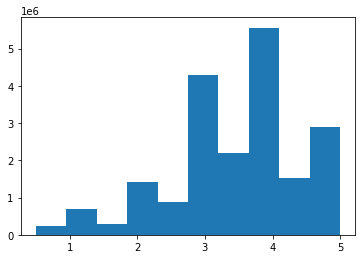

In [39]:
# Anderson normality test is done
print("anderson: ", *stats.anderson(user_movie_df_for_lightGBM["rating"], dist='norm'))

# Histogram plot of price values are shown
plt.hist(user_movie_df_for_lightGBM["rating"])

In [40]:
# Normalization is applied
user_movie_df_for_lightGBM_normalized = user_movie_df_for_lightGBM[user_movie_df_for_lightGBM.columns.difference(['title', '(no genres listed)', 'userId'])].copy()
column_names = user_movie_df_for_lightGBM_normalized.columns

user_movie_df_for_lightGBM_normalized = preprocessing.normalize(user_movie_df_for_lightGBM_normalized)
user_movie_df_for_lightGBM_normalized = pd.DataFrame(user_movie_df_for_lightGBM_normalized,columns = column_names)

anderson:  126663.06416736916 [0.576 0.656 0.787 0.918 1.092] [15.  10.   5.   2.5  1. ]


(array([2759595., 1718773., 2430656., 2515852., 2121179., 3046902.,
        1662729., 1983722.,  821193.,  938763.]),
 array([3.81194212e-06, 2.56848614e-04, 5.09885286e-04, 7.62921957e-04,
        1.01595863e-03, 1.26899530e-03, 1.52203197e-03, 1.77506864e-03,
        2.02810532e-03, 2.28114199e-03, 2.53417866e-03]),
 <BarContainer object of 10 artists>)

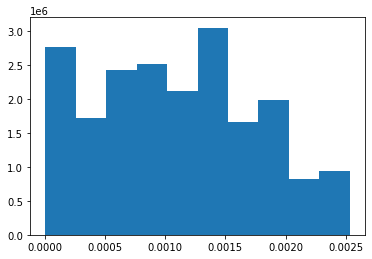

In [41]:
print("anderson: ", *stats.anderson(user_movie_df_for_lightGBM_normalized["rating"], dist='norm'))

# Histogram plot of price values are shown
plt.hist(user_movie_df_for_lightGBM_normalized["rating"])

In [42]:
# Working with normalized data

# Getting dependent and independent variables
X = user_movie_df_for_lightGBM_normalized[user_movie_df_for_lightGBM_normalized.columns.difference(['rating'])]
y = user_movie_df_for_lightGBM_normalized['rating']

# Splttint to train,test,and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2032647)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=2032647)

# Assigning random state 
randomstate = RandomState(2032647)

# lgbm_optimization_parameters
max_depth = randomstate.randint(2,15, size=4)
num_leaves = [2, 4, 8, 16]
n_estimators = randomstate.randint(100,1000, size=4)
learning_rate = [0.1, 0.2, 0.4]

lgbm_optimization_parameters = {    
    'n_estimators' : n_estimators,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,}

# lgbm_searcher 
lgbm = LGBMRegressor(random_state = 2032647)
lgbm_searcher = RandomizedSearchCV(estimator = lgbm, 
                                  param_distributions = lgbm_optimization_parameters,
                                  n_iter = 5,
                                  random_state = 2032647)

#lgbm_search 
lgbm_search = lgbm_searcher.fit(X_train, y_train)

# Obtaining the best model from random search
lgbm_regressor = lgbm_search.best_estimator_ 
lgbm_search.best_params_ 

{'num_leaves': 16, 'n_estimators': 995, 'max_depth': 2, 'learning_rate': 0.4}

In [43]:
# Evaluating the model's R²
y_pred_lgbm = lgbm_regressor.predict(X_validation)
R_square_lgbm = r2_score(y_validation, y_pred_lgbm) 
print(R_square_lgbm)

0.8142272863589621


# Multiple Linear Regression

In [45]:
# prepare the cross-validation procedure
cv = KFold(n_splits=3, random_state=1, shuffle=True)

#model initiation
model = LinearRegression()

#train data is fit into the model
model.fit(X_train, y_train)

# Make predictions
expected = y_test
predicted = model.predict(X_test)

# Summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print(model.intercept_, model.coef_, mse, "\n")
R2 = r2_score(expected,predicted)
print("R squared value is ", R2)

model.get_params()

# Evaluate model with Kfold cross validation
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

-8.352177601470261e-05 [-1.98804060e-01  1.02470732e-01  2.76246625e-01 -3.40153359e-01
 -1.44414888e-01  2.39144275e-01  3.21988405e-01  1.55464633e-01
  4.76146907e-02  2.67497513e-01 -1.70404955e-01  2.21709628e-02
  1.22433762e-01  1.35943493e-01  2.81235559e-02  3.42853649e-02
 -4.65029227e-02  3.37544641e-01  1.49727567e-02  5.51620410e-05
  1.83838214e-03] 1.336621795429305e-07 

R squared value is  0.7101076663971317
Accuracy: nan (nan)


In [ ]:
# Residual plot
sns.residplot(x=expected, y=predicted, lowess=True, color="b")